In [1]:
# # Instalacion de otras librerias
# !pip install colour-science
# !pip install xgboost
# !pip install scikeras
# !pip install yellowbrick

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn import utils

# Ploting
import matplotlib.pyplot as plt
import colour

# Algoritmos de ML
# Scikit learn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                 BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
# Redes Neuronales
import tensorflow as tf
from tensorflow import keras
import scikeras

# Metricas 
from sklearn.metrics import (mean_squared_error, mean_absolute_error)

# Otros 
import datetime
import optuna

# Implementacion de tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard



## Lectura del CSV

In [3]:
# df = pd.read_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/rgb.csv')
# df_xyz = pd.read_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/xyz.csv')
# df = df.merge(df_xyz,how='outer')
# df.to_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/df_rgb_xyz.csv')
# df.head()

In [2]:
df = pd.read_csv('df_rgb_xyz.csv').drop('Unnamed: 0',axis=1)
df['R'] = df['R'] / 100
df['DEE'] = df['DEE'] / 80
df.head()

,R,DEE,Remb,r,g,b,x,y,z
0,0.101691,0.891269,0.5481,0.607739,0.607748,0.610636,0.312052,0.327911,0.360038
1,0.249168,0.539952,0.3979,0.614463,0.662313,0.545797,0.326839,0.373410,0.299751
2,0.914374,0.211320,0.6341,0.643678,0.632023,0.563976,0.331315,0.354632,0.314053
3,0.859463,0.568773,0.8010,0.667089,0.649641,0.526636,0.344984,0.374364,0.280652
4,0.311980,0.182830,0.3469,0.752189,0.582688,0.540596,0.369491,0.343779,0.286731


Parametros esperados de salida

---
* **R:** Radio de Nanoparticula (Dimensiones: nm, Rango: [5, 100])
* **DEE:** Distancia entre Nanoparticulas (Dimensiones: nm, Rango: [5, 80])
* **Remb:** Radio de incrustado (Dimensiones: porcentual, Rango: [0.3, 1])

Parametros esperados de entrada

---
* **r:** Rojo del Espacio de color sRGB (valor de 0 a 1)
* **g:** Verde del Espacio de color sRGB (valor de 0 a 1)
* **b:** Azul del espacio de color sRGB (valor de 0 a 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24635 entries, 0 to 24634
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       24635 non-null  float64
 1   DEE     24635 non-null  float64
 2   Remb    24635 non-null  float64
 3   r       24635 non-null  float64
 4   g       24635 non-null  float64
 5   b       24635 non-null  float64
 6   x       24635 non-null  float64
 7   y       24635 non-null  float64
 8   z       24635 non-null  float64
dtypes: float64(9)
memory usage: 1.7 MB


Se determina la precencia de datos faltantes (NaN), lo cual resulta negativo para este caso

## Identificacion y tratado de valores atipicos

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,24635.0,0.565423,0.284399,0.050000,0.345113,0.560209,0.805104,1.000000
DEE,24635.0,0.474598,0.277197,0.062500,0.233058,0.481660,0.674836,1.000000
Remb,24635.0,0.657977,0.188672,0.300000,0.519609,0.690612,0.775595,1.000000
r,24635.0,0.627914,0.080999,-0.181064,0.574962,0.630622,0.685156,0.880922
g,24635.0,0.601236,0.049293,0.363591,0.575145,0.607490,0.629795,0.740896
b,24635.0,0.595498,0.063144,0.280018,0.565935,0.606192,0.632683,0.756195
x,24635.0,0.321553,0.030290,0.204156,0.300711,0.321979,0.343659,0.438084
y,24635.0,0.330612,0.036470,0.221430,0.301435,0.328984,0.351444,0.464530
z,24635.0,0.347835,0.058343,0.127415,0.314741,0.352387,0.383018,0.533591


Aparentenemnte se encontro un detalle en la columna `r`, el valor minimo no entra dentro del rango especificado anteriormente

Numero de outlayers: 2, Los cuales son: [-0.07122901 -0.18106433]


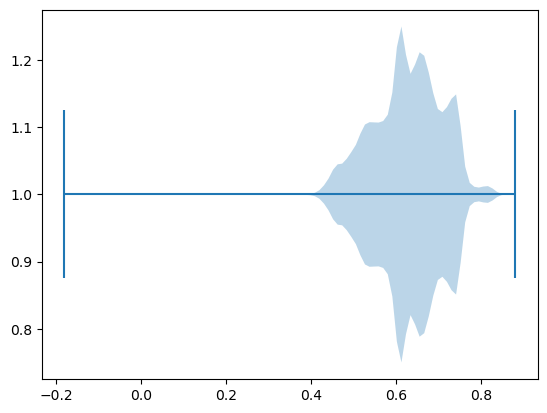

In [5]:
plt.violinplot(df.r,vert=False)
outlayers = df['r'] < 0
outlayers = df[outlayers]
print(f'Numero de outlayers: {outlayers.shape[0]}, Los cuales son: {outlayers["r"].unique()}')

Se corrobora lo anteriormente observado con un diagrama de violin (KDE) y en efecto se cuenta con un valor que sobrepasa el minimo establecido, por lo cual se procede a sustraer la fila donde se encuentra el outlayer.

,count,mean,std,min,25%,50%,75%,max
R,24633.0,0.565397,0.284395,0.050000,0.345107,0.560076,0.805031,1.000000
DEE,24633.0,0.474586,0.277204,0.062500,0.233053,0.481493,0.674823,1.000000
Remb,24633.0,0.657976,0.188673,0.300000,0.519618,0.690612,0.775590,1.000000
r,24633.0,0.627975,0.080715,0.237164,0.575010,0.630646,0.685163,0.880922
g,24633.0,0.601234,0.049294,0.363591,0.575145,0.607489,0.629795,0.740896
b,24633.0,0.595487,0.063135,0.280018,0.565934,0.606191,0.632676,0.756195
x,24633.0,0.321563,0.030274,0.238820,0.300717,0.321979,0.343663,0.438084
y,24633.0,0.330615,0.036469,0.221430,0.301439,0.328984,0.351448,0.464530
z,24633.0,0.347822,0.058328,0.127415,0.314735,0.352387,0.382998,0.533591


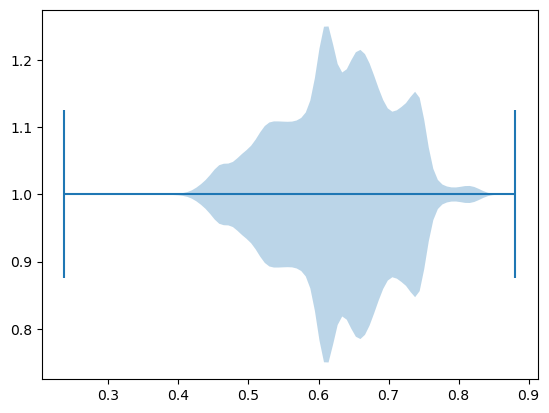

In [6]:
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
plt.violinplot(df.r,vert=False)
df.describe().T

## Creacion de nuevas dataframes con su respectiva variable objetivo

In [7]:
df_R = df.drop(['DEE','Remb','x','y','z'],axis=1)
df_R.head()

,R,r,g,b
0,0.101691,0.607739,0.607748,0.610636
1,0.249168,0.614463,0.662313,0.545797
2,0.914374,0.643678,0.632023,0.563976
3,0.859463,0.667089,0.649641,0.526636
4,0.311980,0.752189,0.582688,0.540596


In [8]:
df_DEE = df.drop(['R','Remb','x','y','z'],axis=1)
df_DEE.head()

,DEE,r,g,b
0,0.891269,0.607739,0.607748,0.610636
1,0.539952,0.614463,0.662313,0.545797
2,0.211320,0.643678,0.632023,0.563976
3,0.568773,0.667089,0.649641,0.526636
4,0.182830,0.752189,0.582688,0.540596


In [9]:
df_Remb = df.drop(['DEE','R','x','y','z'],axis=1)
df_Remb.head()

,Remb,r,g,b
0,0.5481,0.607739,0.607748,0.610636
1,0.3979,0.614463,0.662313,0.545797
2,0.6341,0.643678,0.632023,0.563976
3,0.8010,0.667089,0.649641,0.526636
4,0.3469,0.752189,0.582688,0.540596


## Analisis del las observaciones respecto al espacio de colores CIE

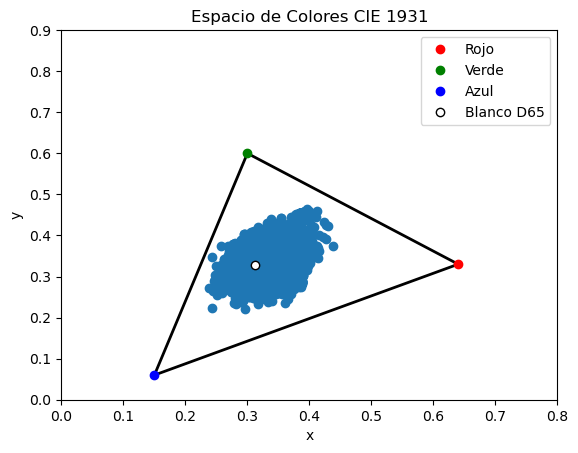

In [10]:
import matplotlib.patches as patches
from matplotlib.path import Path

# Define las coordenadas de cromaticidad de los colores primarios y el blanco
x_red, y_red = 0.64, 0.33
x_green, y_green = 0.30, 0.60
x_blue, y_blue = 0.15, 0.06
x_white, y_white = 0.3127, 0.3290  # Blanco D65

# Define el diagrama de cromaticidad
chromaticity_diagram = Path([
    (x_red, y_red),
    (x_green, y_green),
    (x_blue, y_blue),
    (x_red, y_red)
])

# Crea un gráfico
fig, ax = plt.subplots()

# Añade el diagrama de cromaticidad al gráfico
patch = patches.PathPatch(chromaticity_diagram, facecolor='none', lw=2)
ax.add_patch(patch)

# Añade los puntos de los colores primarios y el blanco
ax.plot(x_red, y_red, 'ro', label='Rojo')
ax.plot(x_green, y_green, 'go', label='Verde')
ax.plot(x_blue, y_blue, 'bo', label='Azul')
ax.plot(x_white, y_white, 'wo', markeredgecolor='k', label='Blanco D65')

# Configura los límites y etiquetas del gráfico
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Espacio de Colores CIE 1931')
ax.legend()

ax.scatter(x = df['x'], y = df['y'])
# Muestra el gráfico
plt.show()


C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # n

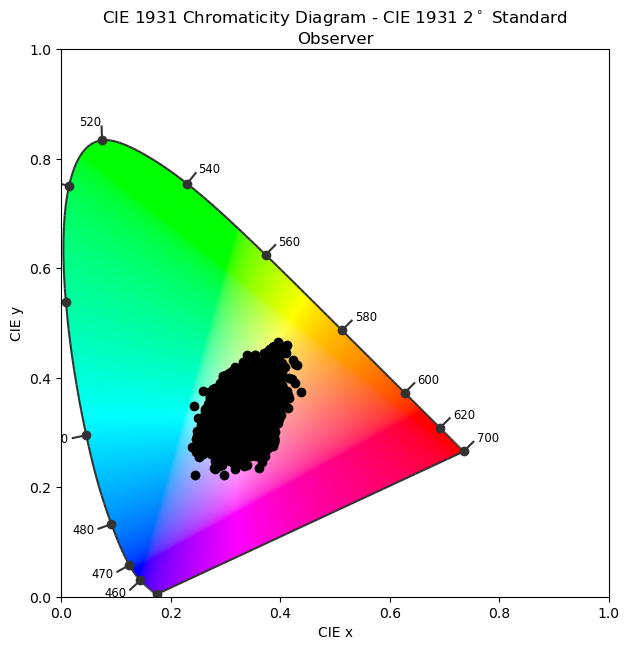

In [11]:
import colour

# Define your scatter plot points (CIE xy coordinates)
x = df['x']
y = df['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

## Data Split en test y training

In [12]:
# R
df_R = utils.shuffle(df_R, random_state = 10)
R_x_train, R_x_test, R_y_train, R_y_test = train_test_split(df_R.drop(['R'],axis=1),df_R['R'],test_size=0.33,random_state=17)
R_x_train.shape,R_x_test.shape

((16504, 3), (8129, 3))

In [13]:
# DEE
df_DEE = utils.shuffle(df_DEE, random_state = 20)
DEE_x_train, DEE_x_test, DEE_y_train, DEE_y_test = train_test_split(df_DEE.drop(['DEE'],axis=1),df_DEE['DEE'],test_size=0.33,random_state=17)
DEE_x_train.shape,DEE_x_test.shape

((16504, 3), (8129, 3))

In [14]:
# Remb
df_Remb = utils.shuffle(df_Remb, random_state = 30)
Remb_x_train, Remb_x_test, Remb_y_train, Remb_y_test = train_test_split(df_Remb.drop(['Remb'],axis=1),df_Remb['Remb'],test_size=0.33,random_state=17)
Remb_x_train.shape,Remb_x_test.shape

((16504, 3), (8129, 3))

## Obtencion de modelos para la prediccion de la variable R




### **Mean Squared Error**
$MSE = \frac{1}{n} \sum_{i=1}^{n} ({y}_{i}-\hat{y}_{i})^{2}$  
**Rango**: 0 ≤ MSE < ∞  
**Ideal**: 0   
### **Root Mean Squared Error**
$RMSE = \sqrt{MSE}$  
**Rango**: 0 ≤ RMSE < ∞  
**Ideal**: 0   
### **Mean Absolute Error**
$MAE = \frac{1}{n} \sum_{i=1}^{n} |{y}_{i}-{\hat{y}}_{i}|$  
**Rango**: 0 ≤ MAE <∞  
**Ideal**: 0 
### **R-square(Coefficient of Determination)**
$R^{2} = 1-\frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^{2}}$  
**Rango**: −∞ ≤ $R^{2}$ ≤1  
**Ideal**: 1 
### **Explained Variance Score**
$EVS = 1 - \frac{Var\{y_{i}-\hat{y}_{i}\}}{Var\{y_{i}\}}$  
**Rango**: −∞ ≤ EVS ≤ 1  
**Ideal**: 1 

## Obtencion de un modelo para el parametro "R" utilizando Scikit-learn

In [16]:
# Creacion de listas para el guardado de los resultados de cada entrenamiento
Model = []
NMSE = []
NMAE = []
cv = KFold(10)

# Guardado de los resultados del entrenamiento del algoritmo 
def input_scores(name, model, x, y):
    Model.append(name)
    NMSE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean())
    NMAE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean())

names = ['Linear Regression', 'Lasso Regression', 
         'ElasticNet Regression', 'SVR', 'Gaussian Regressor', 'Bayesian Ridge',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor']
models = [LinearRegression(), Lasso(), ElasticNet(),
          SVR(), GaussianProcessRegressor(), BayesianRidge(),
          KNeighborsRegressor(metric='wminkowski', p=2, 
                           metric_params={'w': np.random.random(R_x_train.shape[1])}), 
          DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor()]

# Entrenamiento de cada modelo de la lista "models" a lo fuerza bruta
for name, model in zip(names, models):
    input_scores(name, model, R_x_train, np.ravel(R_y_train))

# Creacion de una dataframe a partir de la informacion recolectada
evaluation = pd.DataFrame({'Model': Model,
                           'MSE' : NMSE,
                           'MAE' : NMAE,})
print("FOLLOWING ARE THE TRAINING SCORES FOR R VALUE: ")
evaluation

KeyboardInterrupt: 

Dado a los resultados previos se procedera a hacer un mejor analisis a aquellos algoritmos que obtuvieron un mejor resultado:
* K Neighbors Regressor
* Random Forest Regressor 

## Prediccion con K Neighbors del parametro R
### Busqueda de los mejores hiperparametros

In [ ]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn, R_x_train, R_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


In [ ]:
R_model_knn = KNeighborsRegressor(n_neighbors = 40, weights = 'distance', metric = 'minkowski', p = 1)
R_model_knn.fit(R_x_train, R_y_train)

In [ ]:
knn_pred = R_model_knn.predict(R_x_test)
mse = mean_squared_error(R_y_test, knn_pred)
mae = mean_absolute_error(R_y_test, knn_pred)
print(mse, mae)

## Prediccion con Random Forest
### Busqueda de los mejores hiperparametros

In [ ]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Creación del modelo con los hiperparámetros sugeridos
    model_rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        bootstrap=bootstrap,
        n_jobs=-1
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_rf, R_x_train, R_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


In [ ]:
model_rf = RandomForestRegressor(n_estimators = 70, max_depth = 15, bootstrap =True, n_jobs = -1)
model_rf.fit(R_x_train, R_y_train)

In [ ]:
rf_pred = model_rf.predict(R_x_test)
mse = mean_squared_error(R_y_test, rf_pred)
mae = mean_absolute_error(R_y_test, rf_pred)
print(mse, mae)

# Prediccion de los demas parametros mediante un arreglo en cascada con K-Neighbors

## Parametro Remb

In [17]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn, Remb_x_train, Remb_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-10-17 09:57:08,895] A new study created in memory with name: no-name-fd27760f-7996-499f-a052-2cdd1ee9b18b
[I 2023-10-17 09:57:12,725] Trial 0 finished with value: -0.12205924013647326 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: -0.12205924013647326.
[I 2023-10-17 09:57:12,836] Trial 1 finished with value: -0.12333071164675236 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.12205924013647326.
[I 2023-10-17 09:57:12,937] Trial 2 finished with value: -0.12800423486714288 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: -0.12205924013647326.
[I 2023-10-17 09:57:13,024] Trial 3 finished with value: -0.12391234537239741 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.12205924013647326.
[I 2023-10-17 09:57:13,109] Trial 4 finished w

[I 2023-10-17 09:57:17,156] Trial 38 finished with value: -0.12372786649111389 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 18 with value: -0.12188259353060593.
[I 2023-10-17 09:57:17,250] Trial 39 finished with value: -0.12255220695382012 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 18 with value: -0.12188259353060593.
[I 2023-10-17 09:57:17,447] Trial 40 finished with value: -0.12223612867205806 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'minkowski', 'p': 4}. Best is trial 18 with value: -0.12188259353060593.
[I 2023-10-17 09:57:17,558] Trial 41 finished with value: -0.12186960092066394 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}. Best is trial 41 with value: -0.12186960092066394.
[I 2023-10-17 09:57:17,683] Trial 42 finished with value: -0.12188259353060593 and parameters: {'n_neighbors': 37, 'weights': 'distan

[I 2023-10-17 09:57:21,719] Trial 76 finished with value: -0.12206303065184654 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'minkowski', 'p': 2}. Best is trial 41 with value: -0.12186960092066394.
[I 2023-10-17 09:57:21,843] Trial 77 finished with value: -0.12190330547433345 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}. Best is trial 41 with value: -0.12186960092066394.
[I 2023-10-17 09:57:21,953] Trial 78 finished with value: -0.12363737533201044 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1}. Best is trial 41 with value: -0.12186960092066394.
[I 2023-10-17 09:57:22,071] Trial 79 finished with value: -0.12186960092066394 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 41 with value: -0.12186960092066394.
[I 2023-10-17 09:57:22,225] Trial 80 finished with value: -0.12554613698228717 and parameters: {'n_neighbors': 7, 'weights': 

Valor óptimo de neg_mean_squared_error: -0.12186960092066394
Mejores hiperparámetros: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}


In [31]:
Remb_model_knn = KNeighborsRegressor(n_neighbors = 36, weights = 'distance', metric = 'manhattan',)
Remb_model_knn.fit(Remb_x_train, Remb_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=36, weights='distance')

In [32]:
remb_knn_pred = Remb_model_knn.predict(Remb_x_test)
mse = mean_squared_error(Remb_y_test, remb_knn_pred)
mae = mean_absolute_error(Remb_y_test, remb_knn_pred)
print(mse, mae)

0.0271597848546 0.1216493975


## Parametro R

In [20]:
R_x_train['Remb_pred'] = Remb_model_knn.predict(R_x_train)
R_x_test['Remb_pred'] = Remb_model_knn.predict(R_x_test)
R_x_train.head()

,r,g,b,Remb_pred
15648,0.536358,0.627044,0.626174,0.719651
22634,0.536441,0.599472,0.652045,0.736800
20727,0.652510,0.634633,0.555233,0.709246
5500,0.754260,0.598938,0.520384,0.517995
12921,0.640387,0.671966,0.515780,0.563600


In [21]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn, R_x_train, R_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-10-17 09:57:24,812] A new study created in memory with name: no-name-deba7c26-73b2-4a06-bad4-42fc976fd4d1
[I 2023-10-17 09:57:24,956] Trial 0 finished with value: -0.14242623419676026 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.14242623419676026.
[I 2023-10-17 09:57:25,068] Trial 1 finished with value: -0.14072544497184963 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: -0.14072544497184963.
[I 2023-10-17 09:57:25,201] Trial 2 finished with value: -0.13728755718892852 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: -0.13728755718892852.
[I 2023-10-17 09:57:25,311] Trial 3 finished with value: -0.1389257064219532 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 2 with value: -0.13728755718892852.
[I 2023-10-17 09:57:25,426] Trial 4 finished

[I 2023-10-17 09:57:29,957] Trial 39 finished with value: -0.13784641634237313 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:30,072] Trial 40 finished with value: -0.1390081027942101 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:30,207] Trial 41 finished with value: -0.13583808858751192 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:30,343] Trial 42 finished with value: -0.13620561322223237 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:30,464] Trial 43 finished with value: -0.135650108802356 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}

[I 2023-10-17 09:57:34,860] Trial 78 finished with value: -0.13597396635799722 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:34,981] Trial 79 finished with value: -0.1382787654787572 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:35,151] Trial 80 finished with value: -0.13576882484942496 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:35,304] Trial 81 finished with value: -0.135650108802356 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 14 with value: -0.135650108802356.
[I 2023-10-17 09:57:35,417] Trial 82 finished with value: -0.13589199969998841 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. 

Valor óptimo de neg_mean_squared_error: -0.135650108802356
Mejores hiperparámetros: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}


In [22]:
R_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan', )
R_model_knn.fit(R_x_train, R_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

In [23]:
knn_pred = R_model_knn.predict(R_x_test)
mse = mean_squared_error(R_y_test, knn_pred)
mae = mean_absolute_error(R_y_test, knn_pred)
print(mse, mae)

0.0399131404576 0.138093167896


## Parametro DEE

### Busqueda de los mejores hiperparametros (Sin arreglo en cascada)

In [24]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn, DEE_x_train, DEE_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-10-17 09:57:37,678] A new study created in memory with name: no-name-79b32859-a7fc-482e-b042-307d1352524f
[I 2023-10-17 09:57:37,769] Trial 0 finished with value: -0.1755655822442533 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: -0.1755655822442533.
[I 2023-10-17 09:57:37,855] Trial 1 finished with value: -0.17597704163312636 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.1755655822442533.
[I 2023-10-17 09:57:37,926] Trial 2 finished with value: -0.18423412298749267 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.1755655822442533.
[I 2023-10-17 09:57:38,019] Trial 3 finished with value: -0.17524958047330141 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 3 with value: -0.17524958047330141.
[I 2023-10-17 09:57:38,115] Trial 4 finished with 

[I 2023-10-17 09:57:41,874] Trial 39 finished with value: -0.17581862720501087 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:41,974] Trial 40 finished with value: -0.17471689931279766 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:42,079] Trial 41 finished with value: -0.17458835533615913 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:42,186] Trial 42 finished with value: -0.17464693128422223 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:42,292] Trial 43 finished with value: -0.17457867736268715 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': '

[I 2023-10-17 09:57:46,134] Trial 78 finished with value: -0.17586752973252986 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:46,256] Trial 79 finished with value: -0.1747559620334316 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'minkowski', 'p': 2}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:46,371] Trial 80 finished with value: -0.17545143355402704 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:46,483] Trial 81 finished with value: -0.17457574227031344 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 32 with value: -0.17457574227031344.
[I 2023-10-17 09:57:46,597] Trial 82 finished with value: -0.17457867736268715 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'met

Valor óptimo de neg_mean_squared_error: -0.17457574227031344
Mejores hiperparámetros: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan'}


En este caso los resultados no fueron los esperados. Se decidio empezar con el parametro Remb debido a que era el que presentaba menor error que los demas, a continuacion se realizara el en entrenamiento tomando en cuenta los datos del modelo anterior.

In [25]:
DEE_x_train['Remb_pred'] = Remb_model_knn.predict(DEE_x_train)
DEE_x_test['Remb_pred'] = Remb_model_knn.predict(DEE_x_test)
DEE_x_train['R_pred'] = R_model_knn.predict(DEE_x_train)
DEE_x_test['R_pred'] = R_model_knn.predict(DEE_x_test)
DEE_x_train.head()

,r,g,b,Remb_pred,R_pred
21327,0.659095,0.672347,0.501537,0.692132,0.803371
21854,0.536662,0.626007,0.627068,0.481487,0.589252
11124,0.742727,0.496929,0.624686,0.690840,1.000000
18619,0.580653,0.569367,0.658496,0.722400,0.355401
6491,0.586275,0.672386,0.549918,0.594298,1.000000


### Busqueda de hiperparametros tomando en cuenta el modelo anterior

In [26]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn, DEE_x_train, DEE_y_train, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-10-17 09:57:48,899] A new study created in memory with name: no-name-cb44e2e2-aa16-4ed1-b960-276e9b55cacf
[I 2023-10-17 09:57:49,039] Trial 0 finished with value: -0.1568302623407831 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.1568302623407831.
[I 2023-10-17 09:57:49,218] Trial 1 finished with value: -0.1555717044437937 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'minkowski', 'p': 2}. Best is trial 1 with value: -0.1555717044437937.
[I 2023-10-17 09:57:49,440] Trial 2 finished with value: -0.1560225153754245 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'minkowski', 'p': 2}. Best is trial 1 with value: -0.1555717044437937.
[I 2023-10-17 09:57:49,926] Trial 3 finished with value: -0.16154126291028723 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'minkowski', 'p': 5}. Best is trial 1 with value: -0.1555717044437937.
[I 2023-10-17 09:57:50,113] 

[I 2023-10-17 09:57:56,957] Trial 39 finished with value: -0.15111864274497983 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 19 with value: -0.1510576858846378.
[I 2023-10-17 09:57:57,115] Trial 40 finished with value: -0.1558526304642211 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 19 with value: -0.1510576858846378.
[I 2023-10-17 09:57:57,282] Trial 41 finished with value: -0.1510576858846378 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 19 with value: -0.1510576858846378.
[I 2023-10-17 09:57:57,441] Trial 42 finished with value: -0.15096739717511148 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 42 with value: -0.15096739717511148.
[I 2023-10-17 09:57:57,603] Trial 43 finished with value: -0.15096739717511148 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manha

[I 2023-10-17 09:58:04,255] Trial 78 finished with value: -0.15143099561701054 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 42 with value: -0.15096739717511148.
[I 2023-10-17 09:58:04,421] Trial 79 finished with value: -0.154382441757892 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 42 with value: -0.15096739717511148.
[I 2023-10-17 09:58:04,610] Trial 80 finished with value: -0.15423506657786226 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 42 with value: -0.15096739717511148.
[I 2023-10-17 09:58:04,787] Trial 81 finished with value: -0.1510576858846378 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 42 with value: -0.15096739717511148.
[I 2023-10-17 09:58:04,965] Trial 82 finished with value: -0.1510576858846378 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manha

Valor óptimo de neg_mean_squared_error: -0.15096739717511148
Mejores hiperparámetros: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}


In [27]:
DEE_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan',)
DEE_model_knn.fit(DEE_x_train, DEE_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

In [28]:
dee_knn_pred = DEE_model_knn.predict(DEE_x_test)
mse = mean_squared_error(DEE_y_test, dee_knn_pred)
mae = mean_absolute_error(DEE_y_test, dee_knn_pred)
print(mse, mae)

0.0470152373868 0.150625347394


### Busqueda de hiperparametros tomando en cuenta modelos anteriores

# Resultado:  

* MAE Parametro Remb = 0.1216493975  

* MAE Parametro R =   0.138093167896 

* MAE Parametro DEE = 0.150625347394  

**Promedio**   =      0.1367  
**Rango**: 0 ≤ MAE <∞  